In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 23.7MB/s 
     |████████████████████████████████| 2.9MB 24.8MB/s 
     |████████████████████████████████| 890kB 49.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9e7f81738eef5b336147cba7ce59e8f5c879c3c679f90406c37dbe3342bfb455
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from createModel import *

In [86]:
from demoBERT import *

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ranks before : [38, 2663, 85, 1062, 1233, 5134, 26, 45, 4641, 136]
cover_text:  hello world, today we are going to present you a tutorial about how to cook a turkey. please follow this tutorial carefully, right completed already residing movements solids central distanthipskie

ranks after: [38, 2663, 85, 1062, 1233, 5134, 26, 45, 4641, 136]
. this message is super secret please do not share it


In [87]:
mod, tok = buildModelBERT()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
def gen_fake_text(start_text, start_secret, secret_text):
  ranks = get_ranks(mod, tok, start_secret, secret_text)
  cover_text = generate_cover_text(mod, tok, start_text, ranks)

  output_text = cover_text
  return output_text

In [89]:
start_text = """
Welcome to the Shakespeare festival in London, UK. Today
"""

start_secret = "Secret"
secret_text = "A secret message for Joe"

In [ ]:
# Idea 1: use randomly generated ranks instead of calculated ones
# Idea 2: give only steganographic part (without starting text) to classifier

In [90]:
print(gen_fake_text(start_text, start_secret, secret_text))

welcome to the shakespeare festival in london, uk. today - marry manifestdᵢ


# Getting training data

In [19]:
!pip install Torchtext==0.04

     |████████████████████████████████| 61kB 7.6MB/s 
ERROR: Operation cancelled by user


In [20]:
import torch
import torchtext
#from torchtext.datasets import text_classification
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
#train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](
#    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
train_dataset._data[0][1]

NameError: ignored

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [ ]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [ ]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [ ]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

In [ ]:
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

vocab = train_dataset.get_vocab()
model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, model, vocab, 2)])

# Convert to tensor


In [ ]:
def convert_to_tensor(text, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        return text

In [ ]:
convert_to_tensor('hello my name is', vocab=train_dataset.get_vocab(), ngrams=NGRAMS)

NameError: ignored

In [105]:
from nltk.corpus import brown
import nltk
nltk.download('brown')

news_text = brown.sents(categories=['news'])[:1000]
fake_news = []
true_news = []

secret_text_length = 5

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [106]:
for sentence in news_text:
  if len(sentence) <= secret_text_length:
    continue

  sentence_true = ' '.join(sentence)

  true_news.append(sentence_true)

  sentence_fake = ' '.join(sentence[:-secret_text_length])
  print(sentence_fake)
  sentence_fake = gen_fake_text(sentence_fake, start_secret, secret_text)

  fake_news.append(sentence_fake)

The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that
The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which
The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by
`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size
The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate
It recommended that Fulton legislators act `` to have these laws studied and revised to the end of modernizing
The grand jury commented on a number of other topics , among them the Atlanta and

In [107]:
import string

punctuation_dict = {}
for x in string.punctuation:
  punctuation_dict[ord(x)] = None

print(true_news[1].translate(punctuation_dict))

for i in range(len(true_news)):
  true_news[i] = true_news[i].translate(punctuation_dict)

for i in range(len(fake_news)):
  fake_news[i] = fake_news[i].translate(punctuation_dict)


The jury further said in termend presentments that the City Executive Committee  which had overall charge of the election   deserves the praise and thanks of the City of Atlanta  for the manner in which the election was conducted 


In [108]:
fake_news

['the fulton county grand jury said friday an investigation of atlantas recent primary election produced   no evidence that s downing mar near climb',
 'the jury further said in term  end presentments that the city executive committee which had over  all charge of the election   deserves the praise and thanks of the city of atlanta for the manner in which effect maiden vineyard act cs',
 'the september  october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible   irregularities in the hard  fought primary which was won by democrat bentley rail engine pension',
 '  only a relative handful of such reports was received the jury said   considering the widespread interest in the election the number of voters and the size  bonnie disclose roberta pin',
 'the jury said it did find that many of georgias registration and election laws   are outmoded or inadequate merely ironines peabody goals',
 'it recommended that fulton legislators act   

# Creating and training a model


In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split

destination_folder = './lstm/'

train_test_ratio = 0.90
train_valid_ratio = 0.80

first_n_words = 200

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [110]:
#true_dict = dict({(i, 0) for i in true_news})
#fake_dict = dict({(i, 1) for i in fake_news})
#all_dict = {**true_dict, **fake_dict}
#print(all_dict)

#true_dict = {'text': true_news, 'label': 0}
#fake_dict = {'text': fake_news, 'label': 1}
#all_dict = {**true_dict, **fake_dict}

all_dict = {'text': true_news + fake_news, 'label': [0]*len(true_news)+[1]*len(fake_news)}

df = pd.DataFrame(data=all_dict, columns=['label', 'text'])
df

,label,text
0,0,The Fulton County Grand Jury said Friday an in...
1,0,The jury further said in termend presentments ...
2,0,The SeptemberOctober term jury had been charge...
3,0,Only a relative handful of such reports was r...
4,0,The jury said it did find that many of Georgia...
...,...,...
1779,1,surveys show that one out of three americans...
1780,1,this means that more than 100 million have no ...
1781,1,talking of the rapid population growth upward...
1782,1,in 35 years we have opened 7 000 churches th...


In [111]:
# Read raw data
df_raw = df

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [112]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator

# Models

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [113]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=3, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [114]:

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 1)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

In [115]:

# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [116]:

# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:      
            #print(labels)
            #print(text)     
            #labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in valid_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len.cpu())

                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.device('cpu')
train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [20/410], Train Loss: 0.5201, Valid Loss: 0.4349
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [1/10], Step [40/410], Train Loss: 0.3382, Valid Loss: 0.2959
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [60/410], Train Loss: 0.2291, Valid Loss: 0.2785
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [2/10], Step [80/410], Train Loss: 0.1771, Valid Loss: 0.2592
Model saved to ==> ./lstm//model.pt
Model saved to ==> ./lstm//metrics.pt
Epoch [3/10], Step [100/410], Train Loss: 0.1514, Valid Loss: 0.2940
Epoch [3/10], Step [120/410], Train Loss: 0.1061, Valid Loss: 0.2662
Epoch [4/10], Step [140/410], Train Loss: 0.1023, Valid Loss: 0.2970
Epoch [4/10], Step [160/410], Train Loss: 0.0615, Valid Loss: 0.2747
Epoch [5/10], Step [180/410], Train Loss: 0.0570, Valid Loss: 0.3089
Epoch [5/10], Step [200/410], Train Loss: 0.0387, Valid Loss: 0.2625
Epoch [6/10], Step

Model loaded from <== ./lstm//metrics.pt


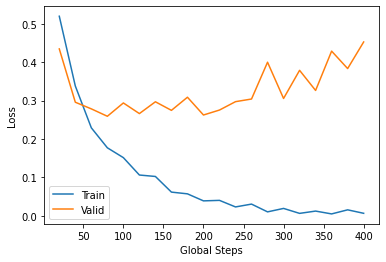

In [117]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== ./lstm//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8381    0.9778    0.9026        90
           0     0.9733    0.8111    0.8848        90

    accuracy                         0.8944       180
   macro avg     0.9057    0.8944    0.8937       180
weighted avg     0.9057    0.8944    0.8937       180



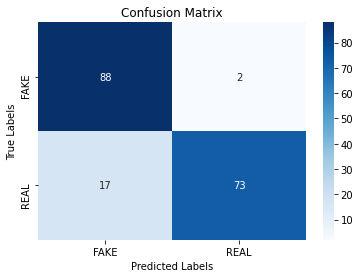

In [118]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len.cpu())

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [ ]:
# daily mail corpus
# fasttext, LSTM, transformer --> 3 classifiers
# 